# Kaggle Titanic Competition
#### Date: 2021-08-27
#### Author: Isaac Lee

# Todo

[X] Feature Exploration  
[X] Feature Engineering  
[X] Initial Models  
[X] Tune Model Parameters  
[X] First submission 01/09/2021 -> Score of 0.68181  
[X] Normalize Features
[X] Try SVC  
[X] Impliment Ensemble Method  
[X] Second Submission -> Score of 0.77033  
[X] Look at feature importance 
[X] Fourth Submission -> Score of 0.78708  
[ ] Implement Neural Net Approach   

## Questions
Null values?  
How does each feature relate to survival chances?  
    - Is there a correlation between Pclass and survived?  
    - Is there a correlation between Sex, Age  
    - Are people that travelled alone more likely to die?  
    - Possible Feature engineering: Name, Ticket and Cabin  
    - Does the location of embarking effect survival rate?  
    - Are people with non-null cabins more likely to survive?

# Imports

In [104]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

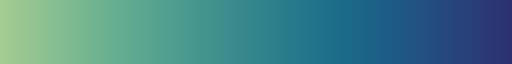

In [105]:
sns.set() # Setting seaborn as default style
sns.set_context("talk")
sns.set(rc={'figure.figsize':(15,10)})
palette = 'crest'
sns.set_palette(palette)
cont_col = ['#1D2562', '#6CB190'] # when we need two contrasting colours
sns.color_palette(palette, as_cmap=True)

In [106]:
train_df = pd.read_csv("train.csv")
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Null Values

In [107]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<AxesSubplot:>

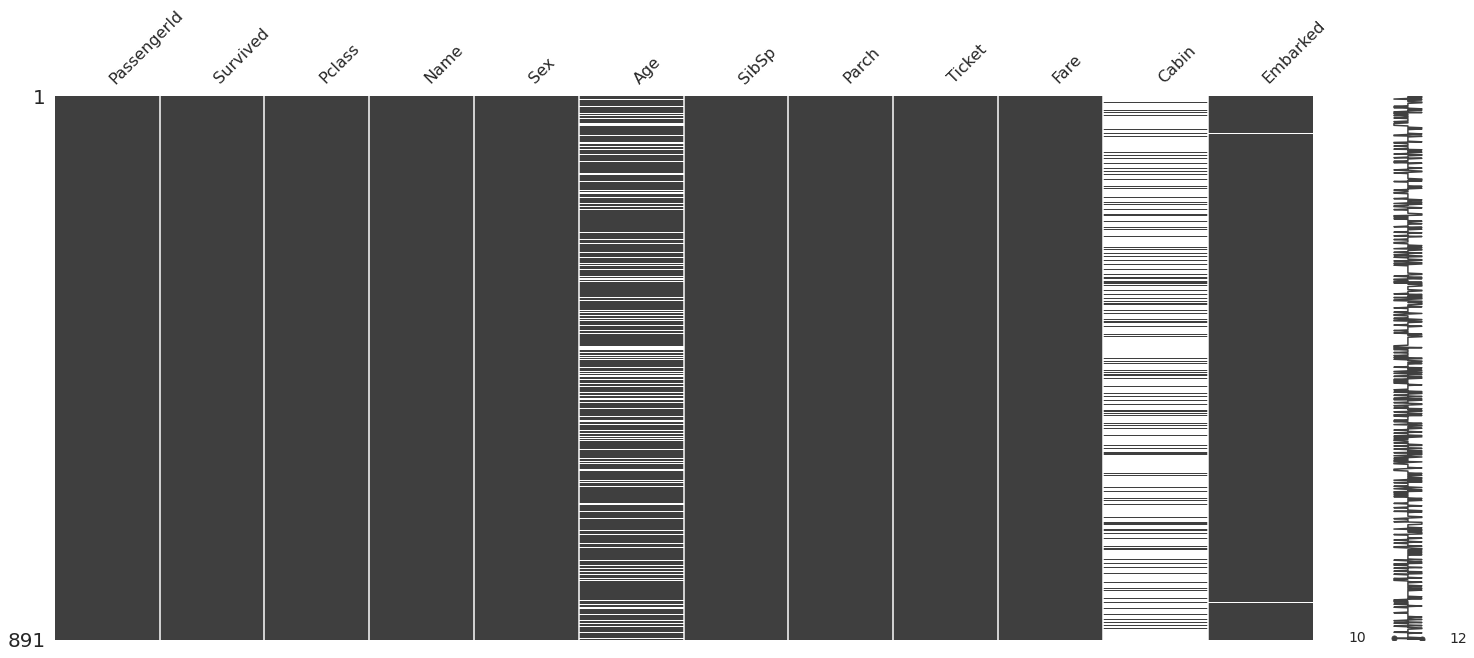

In [108]:
msno.matrix(train_df)

What percentage of people with non-null cabins survived, compared to the percentage of people with null cabins who survived?

In [109]:
died_cabins = train_df["Cabin"][train_df["Survived"] == 0] # Cabins that didn't survive
died_cabins.isnull().sum() / len(died_cabins)

0.8761384335154827

So around 87% of people who died had null values for their cabins

In [110]:
survived_cabins = train_df["Cabin"][train_df["Survived"] == 1] # Cabins that survived
survived_cabins.isnull().sum() / len(survived_cabins)

0.6023391812865497

So around 60% of people that survived had null cabins, which is lower than the amount that didn't survive suggesting a correlation, but 60% is still probably too high to be useful to us. We'll just drop this column
from the df. We also need to examine age and Embarked.

In [111]:
train_df = pd.read_csv("train.csv")
train_df.drop("Cabin", inplace=True, axis=1)

In [112]:
train_df["Age"].isnull().sum() / len(train_df["Age"])

0.19865319865319866

This is too high a percentage for us to just drop the rows with no age, so we'll have to impute the data.

/home/isaac/.virtualenvs/ml_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

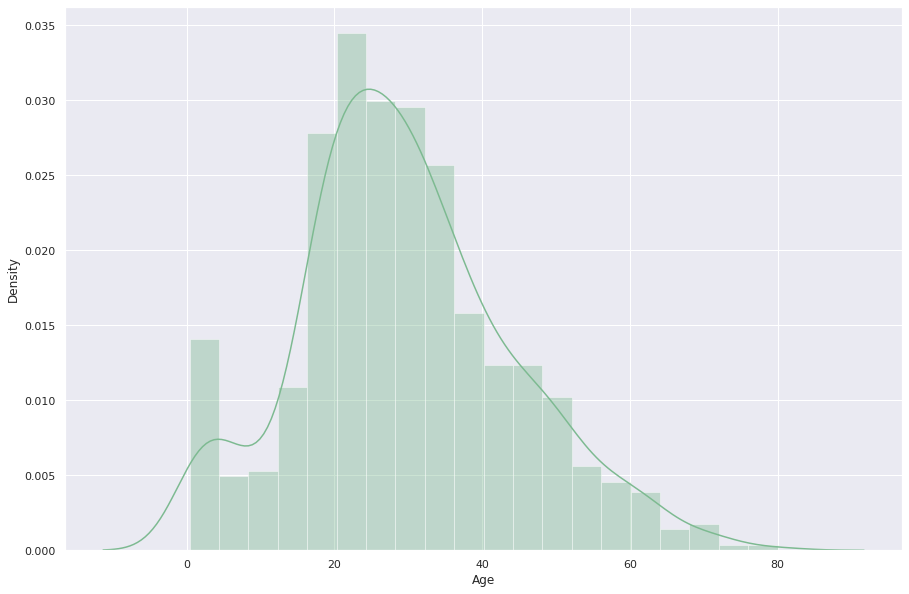

In [113]:
sns.distplot(train_df["Age"])

Data is not too skewed so we use the mean.

In [114]:
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].mean())

Finally for embarked we only have 2 missing values, so we will just drop those rows.

In [115]:
train_df["Embarked"].isnull().sum()

2

In [116]:
train_df = train_df.dropna(how='any', subset=['Embarked'])

In [117]:
train_df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

So now we no longer have null values!

# Feature Exploration

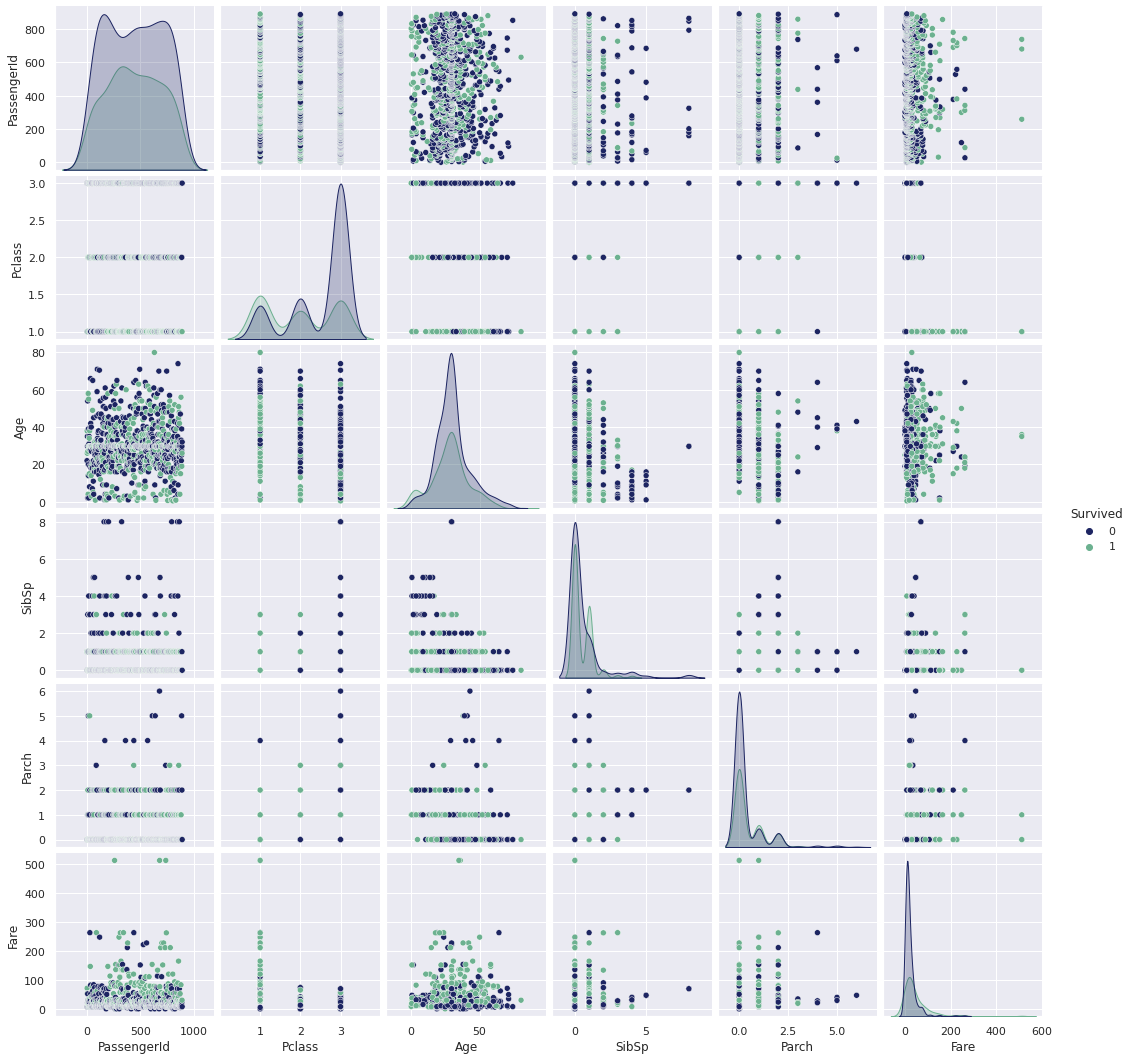

In [118]:
sns.pairplot(train_df, hue='Survived', palette=cont_col)

### Numerical Features

#### Pclass

<AxesSubplot:xlabel='Pclass', ylabel='count'>

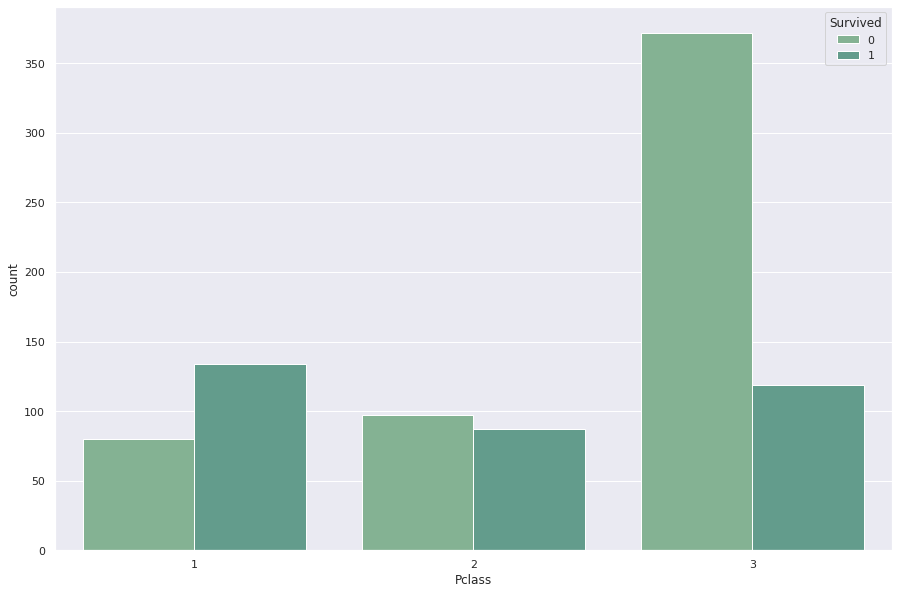

In [119]:
sns.countplot(data=train_df, x=train_df['Pclass'], hue=train_df['Survived'])

In [120]:
pd.pivot_table(train_df[['Survived', 'Pclass']], index='Pclass', aggfunc='mean')

,Survived
Pclass,
1,0.626168
2,0.472826
3,0.242363


So clearly only around a quarter of 3rd class passengers survived whereas around 60% of 1st class survived.
We can see that class is a good indicator for survival.

#### Age

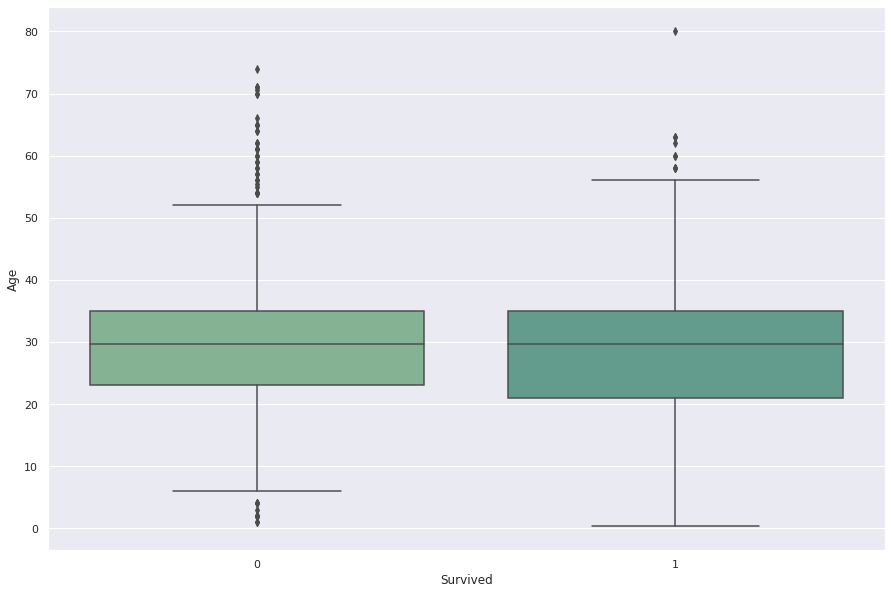

In [121]:
g = sns.boxplot(x=train_df['Survived'], y=train_df['Age'])

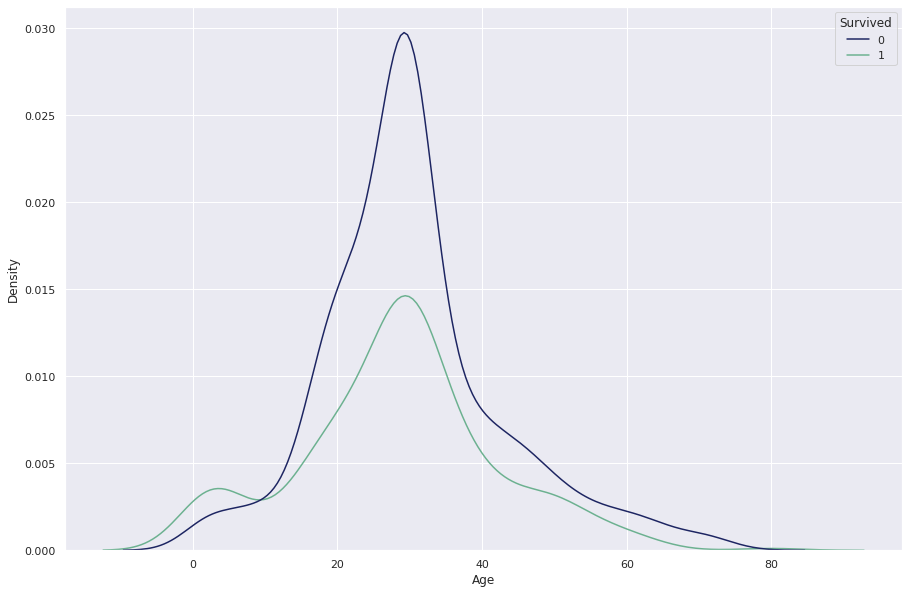

In [122]:
g = sns.kdeplot(data=train_df, x='Age', hue='Survived',palette=cont_col)

It seems like children under 10 have a higher chance of survival, whereas people in the 20-40 years range seem to have the worst chances of survival.

#### SibSP

In [123]:
train_df['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8])

<AxesSubplot:xlabel='SibSp', ylabel='count'>

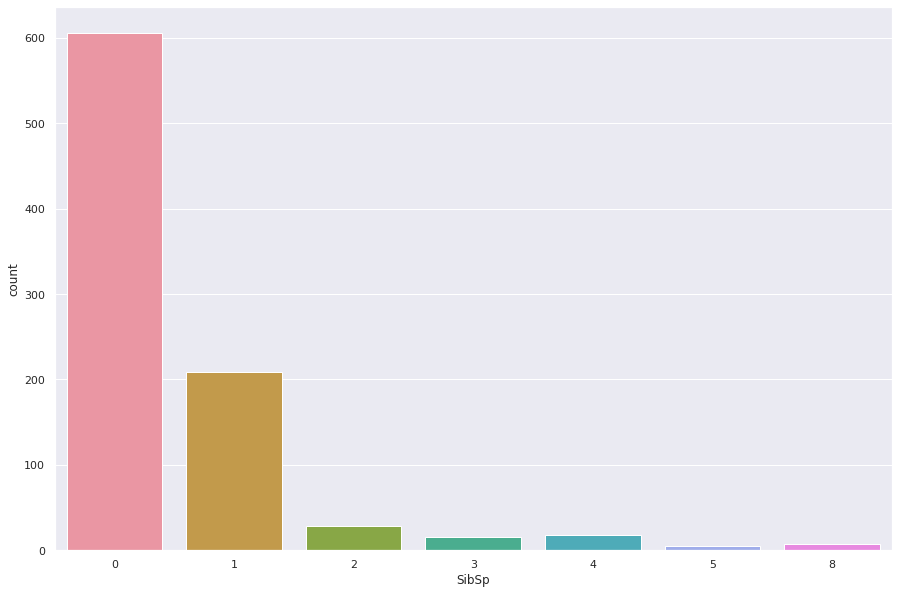

In [124]:
sns.countplot(x=train_df['SibSp'])

Question: do people with > 1 SibSp have a lower chance of surviving?

In [125]:
pd.pivot_table(train_df[['Survived', 'SibSp']], index='SibSp', aggfunc='mean')

,Survived
SibSp,
0,0.343234
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


So clearly, as the number of siblings you have increases, your change of survival decreases,
so if someone has 8 siblings, it is highly likely that they didn't survive. Interestingly
people with 1 SibSp, seem to have the highest chance of survival. In most cases these will be Spouses and I would guess that rich people would tend to have a spouse with them.

#### Parch

In [126]:
pd.pivot_table(train_df[['Survived', 'Parch']], index='Parch', aggfunc='mean')

,Survived
Parch,
0,0.341716
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


In [127]:
pd.pivot_table(train_df[['Survived', 'Parch']], index='Parch', aggfunc='count')

,Survived
Parch,
0,676
1,118
2,80
3,5
4,4
5,5
6,1


#### Fare
I would guess that people who pay a higher fare are more likely to survive.

[(0.0, 300.0)]

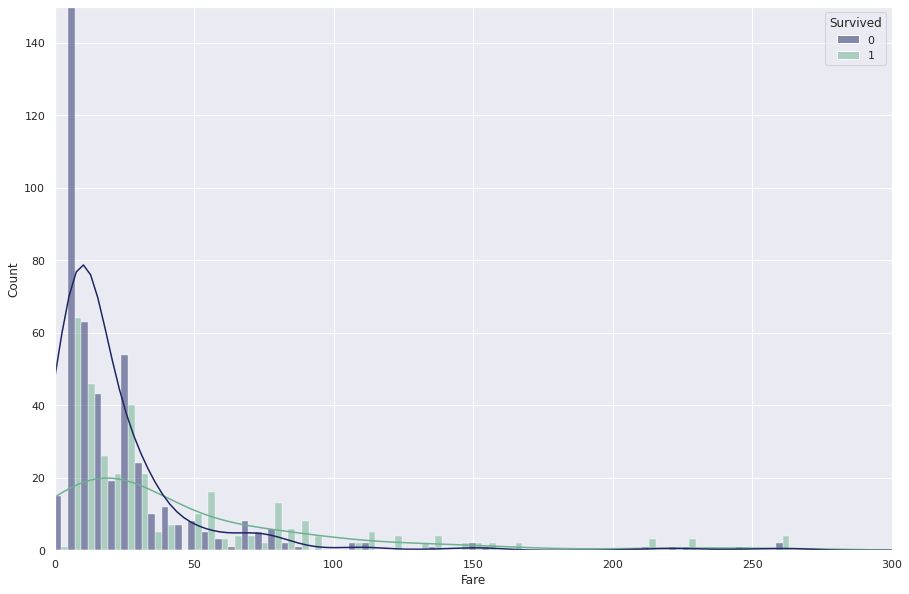

In [128]:
g = sns.histplot(data=train_df, x='Fare', hue='Survived', palette=cont_col, multiple='dodge', kde=True)
g.set(ylim=(0, 150))
g.set(xlim=(0, 300))

To make things easier, we wil separate fare into 5 bins:

In [129]:
train_df['Fare_Binned'] = pd.qcut(train_df['Fare'], 10)

In [130]:
train_df['Fare_Binned'].unique()

[(-0.001, 7.55], (39.688, 77.288], (7.854, 8.05], (8.05, 10.5], (14.454, 21.075], (10.5, 14.454], (26.82, 39.688], (21.075, 26.82], (7.55, 7.854], (77.288, 512.329]]
Categories (10, interval[float64, right]): [(-0.001, 7.55] < (7.55, 7.854] < (7.854, 8.05] < (8.05, 10.5] ... (21.075, 26.82] < (26.82, 39.688] < (39.688, 77.288] < (77.288, 512.329]]

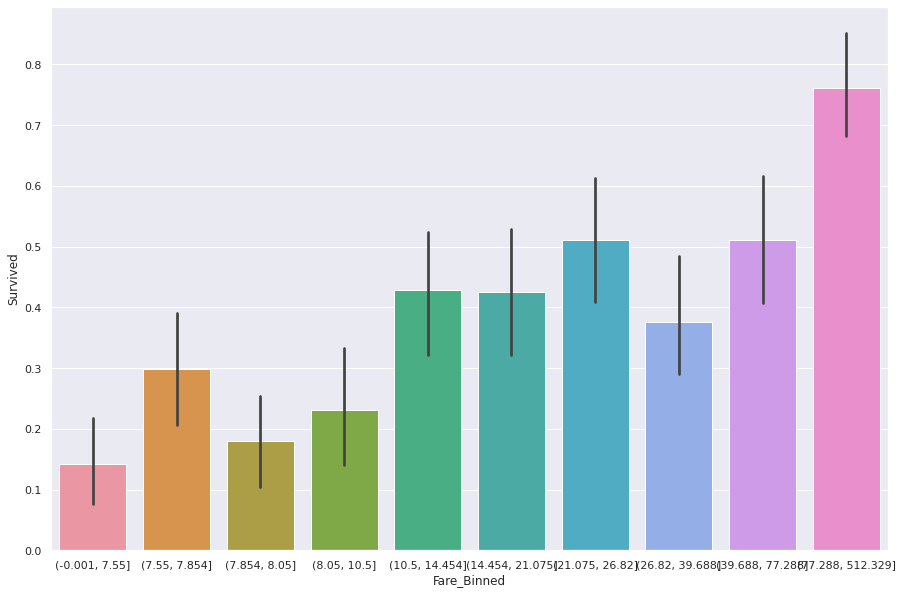

In [131]:
g = sns.barplot(data=train_df, x='Fare_Binned', y='Survived')

Clearly higher fares correlate with higher survival rates.

For our models we will need to normalize the fare.

### Categorical Features

#### Name

In [132]:
train_df['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 889, dtype: object

Question: do people with longer names have a higher chance of survival?

In [133]:
train_df['Name_Len'] = train_df.apply(lambda row : len(row['Name']), axis = 1)

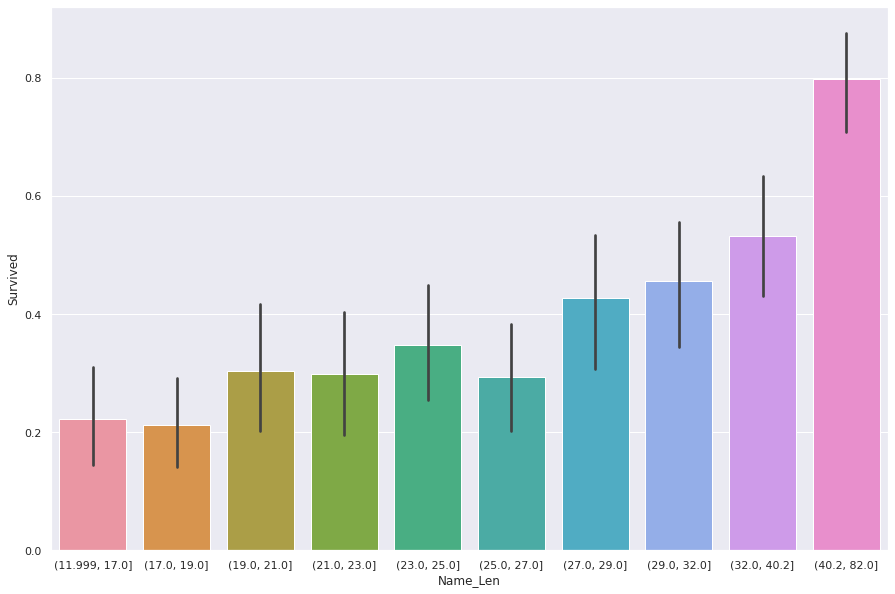

In [134]:
g = sns.barplot(data=train_df, x=pd.qcut(train_df['Name_Len'], 10), y='Survived')


So interestingly it seems that the people with longer names have a higher chance of survival.

#### Sex

I imagine sex will have a large part to play since the men were expected to let the women and children
on to the lifeboats first.

In [135]:
pd.pivot_table(train_df[['Survived', 'Sex']], index='Sex', aggfunc='mean')

,Survived
Sex,
female,0.740385
male,0.188908


So clearly the large majority of females survived and vice versa for the men.

#### Ticket

In [136]:
len(train_df['Ticket'].unique())

680

In [137]:
train_df['Ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 889, dtype: object

We first remove any letters from the tickets to make the data cleaner:

In [138]:
def ticket_len(string):
    """Remove all non-numeric chars from a string and return the length of the number."""
    nums = [str(num) for num in list(range(10))]
    num_only = ''
    for char in string.split()[-1]:
        if char in nums:
            num_only += char
    if num_only == '':
        return 4 # This only happens for the 'LINE' ticket type, which is very rare
    else:
        return len(num_only)

In [139]:
train_df['Ticket_Len'] = train_df.apply(lambda row: ticket_len(row['Ticket']), axis=1)

<AxesSubplot:xlabel='Ticket_Len', ylabel='Survived'>

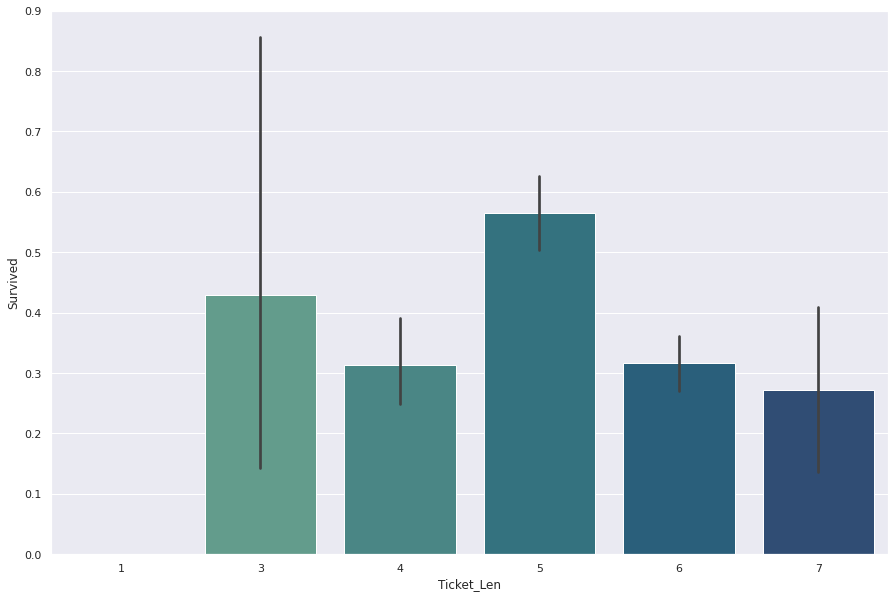

In [140]:
sns.barplot(data=train_df, x='Ticket_Len', y='Survived')

There doesn't seem to be a correlation between survival and char length of the ticket.

In [141]:
def ticket_first_digit(string):
    """Get the first digit of the ticket number"""
    nums = [str(num) for num in list(range(10))]
    num_only = ''
    for char in string.split()[-1]:
        if char in nums:
            return int(char)
    return 0 # We don't find a number

In [142]:
train_df['Ticket_First_Digit'] = train_df.apply(lambda row: ticket_first_digit(row['Ticket']), axis=1)

<AxesSubplot:xlabel='Ticket_First_Digit', ylabel='Survived'>

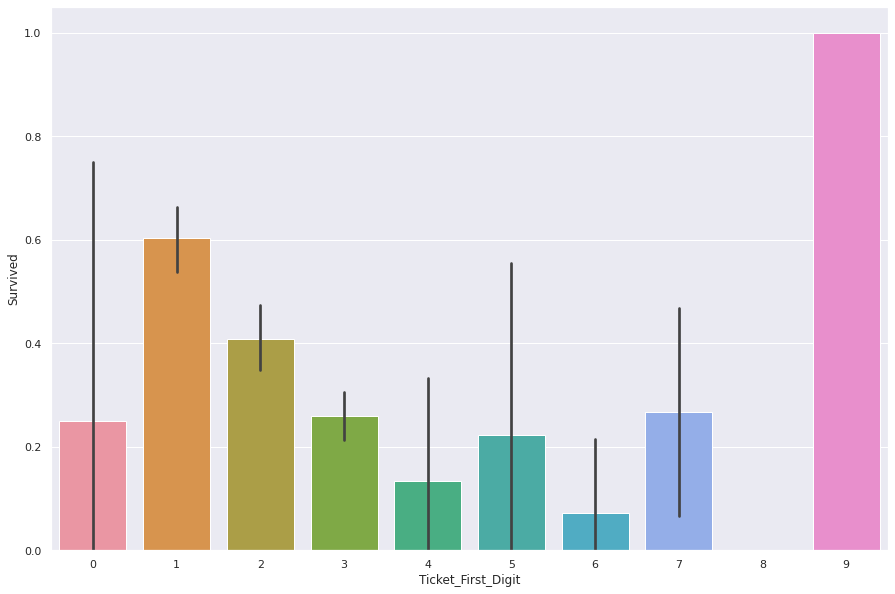

In [143]:
sns.barplot(data=train_df, x='Ticket_First_Digit', y='Survived')

Interestingly it seems that the first number of the ticket has some effect on the survival rate, although
the variances error is quite high.

#### Embarked

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

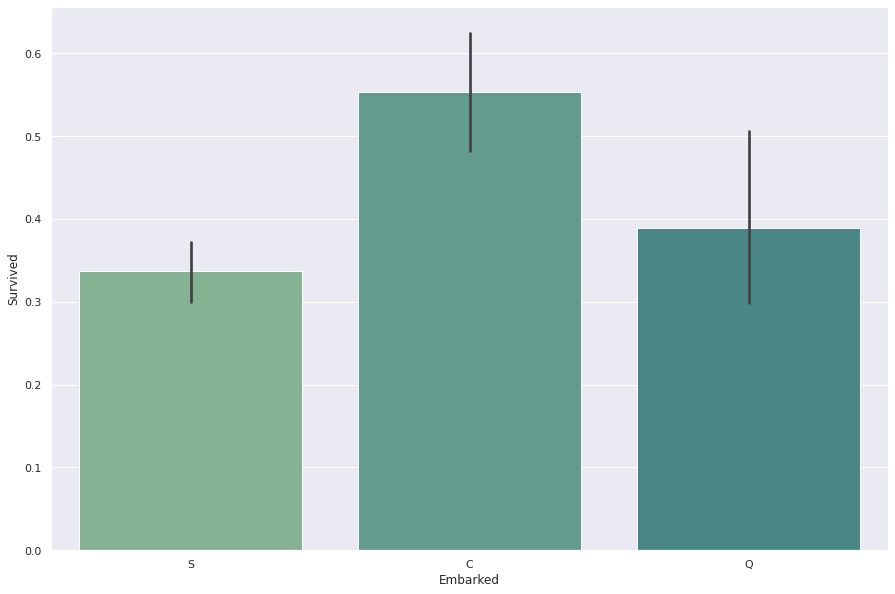

In [144]:
sns.barplot(data=train_df, x='Embarked', y='Survived')

It seems people who embarked from C are the most likely to survive.

# Feature Engineering

In [145]:
train_df.drop(['Name', 'Fare_Binned', 'Ticket', 'Ticket_Len'], inplace=True, axis=1)
#bin_parch(train_df)
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name_Len,Ticket_First_Digit
0,1,0,3,male,22.000000,1,0,7.2500,S,23,2
1,2,1,1,female,38.000000,1,0,71.2833,C,51,1
2,3,1,3,female,26.000000,0,0,7.9250,S,22,3
3,4,1,1,female,35.000000,1,0,53.1000,S,44,1
4,5,0,3,male,35.000000,0,0,8.0500,S,24,3
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.000000,0,0,13.0000,S,21,2
887,888,1,1,female,19.000000,0,0,30.0000,S,28,1
888,889,0,3,female,29.699118,1,2,23.4500,S,40,6
889,890,1,1,male,26.000000,0,0,30.0000,C,21,1


## Scaling Features

In [146]:
train_df['Pclass'].mean()

2.3115860517435323

In [147]:
from math import sqrt
from statistics import stdev
def norm_scaler(df, feature_list):
    """
    Returns : array of normalized feature.
    Args: df : dataframe
          feature_list : list of features to scale.
          """
    for feature in feature_list:
        mu = df[feature].mean()
        s = stdev(df[feature])
        df[feature] = (np.array(df[feature]) - mu) / s

In [148]:
norm_scaler(train_df, ['Fare', 'Pclass', 'Age', 'SibSp', 'Parch', 'Name_Len', 'Ticket_First_Digit'])

## Encoding

In the previous section we already created the Name_Len and Ticket_First_Num features. We now need to encode Sex and Embarked:

In [149]:
train_df['Sex'].unique()

array(['male', 'female'], dtype=object)

In [150]:
def sex_change(sex_str):
    """Returns 1 if female and 0 if male."""
    if sex_str == 'male':
        return 0
    else:
        return 1

In [151]:
# Binary encoding for the Sex feature
train_df['Sex'] = train_df.apply(lambda row: sex_change(row['Sex']), axis=1)
# Onehot encoding the Embarked feature
train_df = pd.get_dummies(train_df, columns=['Embarked'])

In [152]:
train_df.dtypes

PassengerId             int64
Survived                int64
Pclass                float64
Sex                     int64
Age                   float64
SibSp                 float64
Parch                 float64
Fare                  float64
Name_Len              float64
Ticket_First_Digit    float64
Embarked_C              uint8
Embarked_Q              uint8
Embarked_S              uint8
dtype: object

# Modelling

## Train Test Split

In [153]:
# Make the PassengerId the index
train_df.set_index('PassengerId', inplace=True, drop=True)

In [154]:
X = train_df.copy()
y = X.pop('Survived')
sum(y) / len(y)

0.38245219347581555

In [155]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

In [156]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Name_Len,Ticket_First_Digit,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
177,0.824744,0,0.003522,2.243186,0.765466,-0.133407,0.220091,1.245036,0,0,1
266,-0.373291,0,0.489387,-0.474932,-0.474059,-0.434563,-1.073534,-1.091707,0,0,1
344,-0.373291,0,-0.358831,-0.474932,-0.474059,-0.384258,1.621518,-0.312792,0,0,1
230,0.824744,1,0.003522,2.243186,0.765466,-0.133407,-0.426722,1.245036,0,0,1
431,-1.571327,0,-0.127498,-0.474932,-0.474059,-0.111609,1.513716,-1.091707,0,0,1


## General Model Function

In [157]:
from sklearn.model_selection import cross_val_score
def model(clf):
    clf.fit(X_train, y_train)
    # Model on test data
    y_test_pred = clf.predict(X_test)
    clf_test_accuracy = accuracy_score(y_test, y_test_pred)
    # Model on train data
    y_train_pred = clf.predict(X_train)
    clf_train_accuracy = accuracy_score(y_train, y_train_pred)
    # Cross Val
    clf_cv_scores = cross_val_score(clf, X_test, y_test, cv=5)
    clf_cv_SE = (1/sqrt(len(clf_cv_scores))) * stdev(clf_cv_scores)
    # Print Results
    print(f"Test Accuracy: {clf_test_accuracy}")
    print(">" * 30)
    print(f"Train Accuracy: {clf_train_accuracy}")
    print(">" * 30)
    print(f"Mean Cross Val Score: ", np.mean(clf_cv_scores))
    print(">" * 30)
    print(f"Cross Val Standard Error: ", clf_cv_SE)

## Naive Bayes

In [158]:
# Imports
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from math import sqrt
from statistics import stdev
# Fitting the model
gnb = GaussianNB()
model(gnb)
gnb = GaussianNB()

Test Accuracy: 0.797752808988764
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Train Accuracy: 0.8002812939521801
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Mean Cross Val Score:  0.7471428571428571
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Cross Val Standard Error:  0.03574742730366678


## KNN

In [159]:
from sklearn.neighbors import KNeighborsClassifier
# Fitting the model
knn = KNeighborsClassifier(n_neighbors=20)
model(knn)

Test Accuracy: 0.8033707865168539
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Train Accuracy: 0.8171589310829818
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Mean Cross Val Score:  0.7580952380952382
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Cross Val Standard Error:  0.03710468123585639


## SVC

In [160]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
svc = make_pipeline(StandardScaler(), SVC(probability=True, C=0.1))
model(svc)

Test Accuracy: 0.7640449438202247
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Train Accuracy: 0.8241912798874824
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Mean Cross Val Score:  0.6517460317460316
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Cross Val Standard Error:  0.0055294169677302775


In [161]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
svc = make_pipeline(StandardScaler(), SVC(probability=True))
model(svc)

Test Accuracy: 0.7808988764044944
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Train Accuracy: 0.8452883263009845
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Mean Cross Val Score:  0.8038095238095238
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Cross Val Standard Error:  0.03275615182663085


## Random Forest

In [162]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=20,
                            min_samples_split=100, max_depth=3)
model(rf)

Test Accuracy: 0.7921348314606742
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Train Accuracy: 0.8241912798874824
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Mean Cross Val Score:  0.6517460317460316
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Cross Val Standard Error:  0.0055294169677302775


## XGBoost

In [163]:
import xgboost as xgb_model
xgb = xgb_model.XGBClassifier( # trying with random parameters
    random_state=420,
    learning_rate=0.01,
    n_estimators=10,
    max_depth=4,
    min_child_weight=2,
    subsample=0.5,
    colsample_bytree=1,
    objective = 'binary:logistic',
    eval_metric = 'error',
    scale_pos_weight=1,
    use_label_encoder=False) 
                                    
xgb.fit(X_train,
        y_train,
        verbose=True,
        early_stopping_rounds=10,
        eval_metric='error',
        eval_set=[(X_test, y_test)])

print("XGBoost Performance")
xgb_test_accuracy = xgb.score(X_test,y_test)
xgb_train_accuracy = xgb.score(X_train,y_train)
print(f"XGBoost accuracy on test data: {xgb_test_accuracy}")
print(f"XGBoost accuracy on training data: {xgb_train_accuracy}")
# Cross Val
xgb_cv_scores = cross_val_score(xgb, X_test, y_test, cv=5)
xgb_cv_SE = (1/sqrt(len(xgb_cv_scores))) * stdev(xgb_cv_scores)
print("xgb mean cross val score: ", np.mean(xgb_cv_scores))
print("xgb cross val standard error: ", xgb_cv_SE)

[0]	validation_0-error:0.21910
[1]	validation_0-error:0.23034
[2]	validation_0-error:0.23034
[3]	validation_0-error:0.22472
[4]	validation_0-error:0.20225
[5]	validation_0-error:0.20786
[6]	validation_0-error:0.20786
[7]	validation_0-error:0.23034
[8]	validation_0-error:0.22472
[9]	validation_0-error:0.22472
XGBoost Performance
XGBoost accuracy on test data: 0.797752808988764
XGBoost accuracy on training data: 0.8410689170182841
xgb mean cross val score:  0.758888888888889
xgb cross val standard error:  0.03675245924107759


### Hyper Parameter Tuning

In [164]:
from sklearn.model_selection import GridSearchCV

xgb = xgb_model.XGBClassifier(
    objective= 'binary:logistic',
    seed=420,
    use_label_encoder=False
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(10, 50, 220),
    'learning_rate': [0.1, 0.01, 0.05]
}
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

#grid_search.fit(X_train, y_train)

In [165]:
grid_search.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [166]:
xgb = xgb_model.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1,monotone_constraints='()',
              n_estimators=10, n_jobs=8, num_parallel_tree=1, random_state=420,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=420,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=10)
xgb.fit(X_train,
        y_train,
        verbose=False,
        early_stopping_rounds=10,
        eval_metric='error',
        eval_set=[(X_test, y_test)])

print("Tuned XGBoost Performance")
xgb_test_accuracy = xgb.score(X_test,y_test)
xgb_train_accuracy = xgb.score(X_train,y_train)
print(f"Tuned XGBoost accuracy on test data: {xgb_test_accuracy}")
print(f"Tuned XGBoost accuracy on training data: {xgb_train_accuracy}")
# Cross Val
xgb_cv_scores = cross_val_score(xgb, X_test, y_test, cv=5)
xgb_cv_SE = (1/sqrt(len(xgb_cv_scores))) * stdev(xgb_cv_scores)
print("Tuned xgb mean cross val score: ", np.mean(xgb_cv_scores))
print("Tuned xgb cross val standard error: ", xgb_cv_SE)

Tuned XGBoost Performance
Tuned XGBoost accuracy on test data: 0.7696629213483146
Tuned XGBoost accuracy on training data: 0.8340365682137834
[15:40:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric u

## Feature Importances

### XGBoost

/home/isaac/.virtualenvs/ml_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

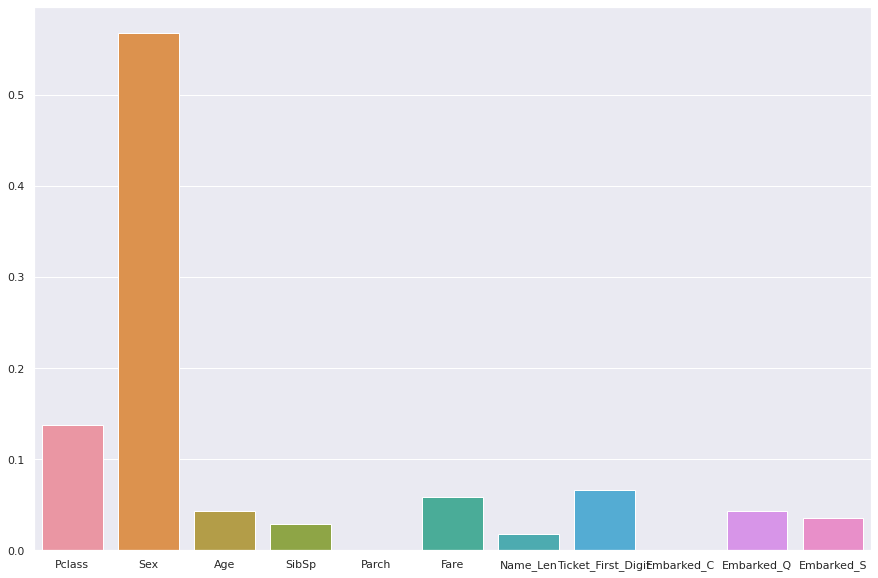

In [65]:
sns.barplot(X.columns, xgb.feature_importances_)

## Ensemble Methods

In [66]:
from sklearn.ensemble import VotingClassifier
# Soft voting classifier
eclf = VotingClassifier(estimators=[('svc', svc), ('xgb', xgb)], voting='soft')
model(eclf)

[11:59:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:59:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:59:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:59:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

# Submissions

In [209]:
# Importing the test_df
test_df = pd.read_csv("test.csv")
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Finally for embarked we only have 2 missing values, so we will just drop those rows.

In [210]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [211]:
# Dealing with Null values
test_df["Age"] = test_df["Age"].fillna(test_df["Age"].mean())
test_df = test_df.dropna(how='any', subset=['Embarked'])
# We can't just drop the row with fare since we must have 418 rows for the kaggle submission,
# So instead we will use the mean fare
test_df["Fare"] = test_df["Fare"].fillna(test_df["Fare"].mean())

In [212]:
# Make the PassengerId the index so it doesn't get in the way of the model
passenger_id = test_df.pop('PassengerId')

In [213]:
test_df['Name_Len'] = test_df.apply(lambda row : len(row['Name']), axis = 1)
test_df['Ticket_First_Digit'] = test_df.apply(lambda row: ticket_first_digit(row['Ticket']), axis=1)
# Binary encoding for the Sex feature
test_df['Sex'] = test_df.apply(lambda row: sex_change(row['Sex']), axis=1)
# Dropping unused features
test_df.drop(['Name', 'Ticket', 'Cabin'], inplace=True, axis=1)
# Onehot encoding the Embarked feature
test_df = pd.get_dummies(test_df, columns=['Embarked'])

In [214]:
test_df.isnull().sum()

Pclass                0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Fare                  0
Name_Len              0
Ticket_First_Digit    0
Embarked_C            0
Embarked_Q            0
Embarked_S            0
dtype: int64

In [215]:
# Scaling the test data
norm_scaler(test_df, ['Fare', 'Pclass', 'Age', 'SibSp', 'Parch', 'Name_Len', 'Ticket_First_Digit'])

In [216]:
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Name_Len,Ticket_First_Digit,Embarked_C,Embarked_Q,Embarked_S
0,0.872436,0,0.334592,-0.498872,-0.399769,-0.497811,-1.151639,0.509265,0,1,0
1,0.872436,1,1.323944,0.616254,-0.399769,-0.512660,0.452978,0.509265,0,0,1
2,-0.315441,0,2.511166,-0.498872,-0.399769,-0.464532,-0.249042,-0.282083,0,1,0
3,0.872436,0,-0.259019,-0.498872,-0.399769,-0.482888,-1.151639,0.509265,0,0,1
4,0.872436,1,-0.654760,0.616254,0.619154,-0.417971,1.656441,0.509265,0,0,1


In [217]:
svc = make_pipeline(StandardScaler(), SVC(probability=True))
knn = KNeighborsClassifier(n_neighbors=20)
eclf = VotingClassifier(estimators=[('svc', svc), ('xgb', xgb)], voting='soft')
# Training on the whole of train_df
eclf.fit(X, y)
# Model on test data
y_final_pred = eclf.predict(test_df)

NameError: name 'VotingClassifier' is not defined

In [207]:
# Joining passenger_id and y_final_pred
passenger_id.reset_index(drop=True, inplace=True)
submission_df = pd.concat([passenger_id, pd.Series(y_final_pred, name='Survived')], axis=1) 

ValueError: Data must be 1-dimensional

In [ ]:
submission_df.to_csv("submission4.csv", index=False)

# Neural Net Experimenting

In [202]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
df = pd.read_csv('train.csv')

# Make the PassengerId the index so it doesn't get in the way of the model
passenger_id = df.pop('PassengerId')
# Dealing with Null values
df["Age"] = df["Age"].fillna(df["Age"].mean())
df = df.dropna(how='any', subset=['Embarked'])
# We can't just drop the row with fare since we must have 418 rows for the kaggle submission,
# So instead we will use the mean fare
df["Fare"] = df["Fare"].fillna(df["Fare"].mean())
# Change Name to Name_Len Feature Engineering
df['Name_Len'] = df.apply(lambda row : len(row['Name']), axis = 1)
# Use the first digit of the numerical part of the ticket
df['Ticket_First_Digit'] = df.apply(lambda row: ticket_first_digit(row['Ticket']), axis=1)
# Binary encoding for the Sex feature
df['Sex'] = df.apply(lambda row: sex_change(row['Sex']), axis=1)
# Dropping unused features
df.drop(['Name', 'Ticket', 'Cabin'], inplace=True, axis=1)
# Onehot encoding the Embarked feature
df = pd.get_dummies(df, columns=['Embarked'])
# Norm Scaling features
norm_scaler(df, ['Fare', 'Pclass', 'Age', 'SibSp', 'Parch', 'Name_Len', 'Ticket_First_Digit'])

X = df.copy()
y = X.pop('Survived')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Name_Len,Ticket_First_Digit,Embarked_C,Embarked_Q,Embarked_S
0,0,0.824744,0,-0.590163,0.431108,-0.474059,-0.499958,-0.426722,-0.312792,0,0,1
1,1,-1.571327,1,0.643609,0.431108,-0.474059,0.788503,2.591737,-1.091707,1,0,0
2,1,0.824744,1,-0.281720,-0.474932,-0.474059,-0.486376,-0.534524,0.466122,0,0,1
3,1,-1.571327,1,0.412277,0.431108,-0.474059,0.422623,1.837122,-1.091707,0,0,1
4,0,0.824744,0,0.412277,-0.474932,-0.474059,-0.483861,-0.318920,0.466122,0,0,1


In [203]:
# https://www.pluralsight.com/guides/deep-learning-model-perform-binary-classification
import tensorflow as tf
from tensorflow import keras
from statistics import stdev
from math import sqrt

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(11,)),
    keras.layers.Dense(11, activation=tf.nn.relu),
	keras.layers.Dense(11, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, batch_size=25)

test_loss, test_acc = model.evaluate(X_test, y_test)



Epoch 1/100
25/25 [==============================] - 0s 691us/step - loss: 0.7014 - accuracy: 0.5016
Epoch 2/100
25/25 [==============================] - 0s 752us/step - loss: 0.6574 - accuracy: 0.6994
Epoch 3/100
25/25 [==============================] - 0s 738us/step - loss: 0.6259 - accuracy: 0.7090
Epoch 4/100
25/25 [==============================] - 0s 697us/step - loss: 0.5988 - accuracy: 0.7331
Epoch 5/100
25/25 [==============================] - 0s 655us/step - loss: 0.5747 - accuracy: 0.7508
Epoch 6/100
25/25 [==============================] - 0s 689us/step - loss: 0.5499 - accuracy: 0.7765
Epoch 7/100
25/25 [==============================] - 0s 657us/step - loss: 0.5250 - accuracy: 0.7894
Epoch 8/100
25/25 [==============================] - 0s 725us/step - loss: 0.5011 - accuracy: 0.8055
Epoch 9/100
25/25 [==============================] - 0s 672us/step - loss: 0.4827 - accuracy: 0.8023
Epoch 10/100
25/25 [==============================] - 0s 741us/step - loss: 0.4639 - accura

In [204]:
model.fit(X, y, epochs=100, batch_size=25)


Epoch 1/100
36/36 [==============================] - 0s 736us/step - loss: 0.3923 - accuracy: 0.8369
Epoch 2/100
36/36 [==============================] - 0s 666us/step - loss: 0.3879 - accuracy: 0.8324
Epoch 3/100
36/36 [==============================] - 0s 820us/step - loss: 0.3850 - accuracy: 0.8346
Epoch 4/100
36/36 [==============================] - 0s 729us/step - loss: 0.3827 - accuracy: 0.8346
Epoch 5/100
36/36 [==============================] - 0s 645us/step - loss: 0.3818 - accuracy: 0.8380
Epoch 6/100
36/36 [==============================] - 0s 671us/step - loss: 0.3799 - accuracy: 0.8403
Epoch 7/100
36/36 [==============================] - 0s 721us/step - loss: 0.3792 - accuracy: 0.8414
Epoch 8/100
36/36 [==============================] - 0s 725us/step - loss: 0.3781 - accuracy: 0.8425
Epoch 9/100
36/36 [==============================] - 0s 703us/step - loss: 0.3779 - accuracy: 0.8414
Epoch 10/100
36/36 [==============================] - 0s 692us/step - loss: 0.3773 - accura

In [222]:

test_df['Survived'] = model.predict(test_df)
test_df['Survived'] = test_df['Survived'].apply(lambda x: round(x,0)).astype('int')

In [223]:
#submission_df = test_df[['PassengerId', 'Survived']]
# Joining passenger_id and y_final_pred
passenger_id.reset_index(drop=True, inplace=True)
submission_df = pd.concat([passenger_id, test_df['Survived']], axis=1) 

In [226]:
submission_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [227]:
submission_df.to_csv("submission5.csv", index=False)